Step 2000, Energy: -238.81113940497386
n=1, P_n^AA=0.3100, P_n^AB=0.3800, P_n^BB=0.3100
n=2, P_n^AA=0.2700, P_n^AB=0.4600, P_n^BB=0.2700
n=3, P_n^AA=0.2600, P_n^AB=0.4800, P_n^BB=0.2600
n=4, P_n^AA=0.2200, P_n^AB=0.5600, P_n^BB=0.2200
n=5, P_n^AA=0.2300, P_n^AB=0.5400, P_n^BB=0.2300
n=6, P_n^AA=0.2200, P_n^AB=0.5600, P_n^BB=0.2200
n=7, P_n^AA=0.2200, P_n^AB=0.5600, P_n^BB=0.2200
n=8, P_n^AA=0.2300, P_n^AB=0.5400, P_n^BB=0.2300
n=9, P_n^AA=0.2300, P_n^AB=0.5400, P_n^BB=0.2300
n=10, P_n^AA=0.2400, P_n^AB=0.5200, P_n^BB=0.2400
Step 4000, Energy: -235.83460490534918
n=1, P_n^AA=0.2800, P_n^AB=0.4400, P_n^BB=0.2800
n=2, P_n^AA=0.2800, P_n^AB=0.4400, P_n^BB=0.2800
n=3, P_n^AA=0.2300, P_n^AB=0.5400, P_n^BB=0.2300
n=4, P_n^AA=0.2400, P_n^AB=0.5200, P_n^BB=0.2400
n=5, P_n^AA=0.2000, P_n^AB=0.6000, P_n^BB=0.2000
n=6, P_n^AA=0.2100, P_n^AB=0.5800, P_n^BB=0.2100
n=7, P_n^AA=0.2600, P_n^AB=0.4800, P_n^BB=0.2600
n=8, P_n^AA=0.2700, P_n^AB=0.4600, P_n^BB=0.2700
n=9, P_n^AA=0.3000, P_n^AB=0.4000, P_n^

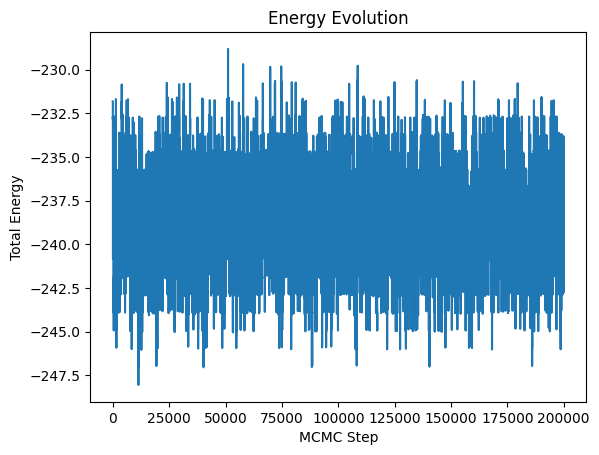

In [11]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# 参数设置
N = 100  # 粒子数
num_A = 50  # A 的初始数量
num_B = N - num_A  # B 的初始数量
n_max = 10  # 最大相邻距离
beta = 1.0  # 逆温度
sigma = 2**(-1/6)  # Lennard-Jones归一化参数
epsilon_matrix = {
    ('A', 'A'): 1,
    ('A', 'B'): 2,
    ('B', 'A'): 2,
    ('B', 'B'): 4
}

# 初始化粒子类别，保持 A 和 B 的数量不变
particles = np.array(['A'] * num_A + ['B'] * num_B)
np.random.shuffle(particles)

# Lennard-Jones能量函数
def lennard_jones(r, epsilon):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

# 能量计算（包含循环边值条件）
def total_energy(particles):
    energy = 0.0
    for i in range(N):
        for j in range(1, n_max + 1):
            # 考虑循环边界
            neighbor = (i + j) % N
            r = np.abs(j)
            epsilon = epsilon_matrix[tuple(sorted((particles[i], particles[neighbor])))]
            energy += lennard_jones(r, epsilon)
    return energy

# 统计距离为 n 的点对分布（包含循环边值条件）
def calculate_pair_distribution(particles):
    pair_counts = defaultdict(lambda: {"AA": 0, "AB": 0, "BB": 0})
    for i in range(N):
        for j in range(1, n_max + 1):
            # 考虑循环边界
            neighbor = (i + j) % N
            n = j
            pair_type = particles[i] + particles[neighbor]
            if pair_type == 'AA':
                pair_counts[n]["AA"] += 1
            elif pair_type in ('AB', 'BA'):  # AB 和 BA 是对称的
                pair_counts[n]["AB"] += 1
            elif pair_type == 'BB':
                pair_counts[n]["BB"] += 1

    # 归一化为概率
    pair_distributions = {}
    for n, counts in pair_counts.items():
        total = counts["AA"] + counts["AB"] + counts["BB"]
        pair_distributions[n] = {
            "P_n^AA": counts["AA"] / total,
            "P_n^AB": counts["AB"] / total,
            "P_n^BB": counts["BB"] / total
        }
    return pair_distributions

# MCMC更新（保持A和B数量固定，包含数值稳定性处理）
def mcmc_step_fixed(particles, energy):
    # 随机选择两个粒子进行交换
    i, j = np.random.choice(range(N), size=2, replace=False)
    if particles[i] == particles[j]:  # 如果两个粒子类别相同，跳过交换
        return particles, energy

    # 创建新状态（交换类别）
    new_particles = particles.copy()
    new_particles[i], new_particles[j] = new_particles[j], new_particles[i]

    # 计算新能量
    new_energy = total_energy(new_particles)
    delta_energy = new_energy - energy

    # 数值稳定处理：log 比较代替 exp
    if delta_energy < 0 or np.log(np.random.rand()) < -beta * delta_energy:
        return new_particles, new_energy
    else:
        return particles, energy

# 初始化
energy = total_energy(particles)
samples = []
energy_history = []

# 运行MCMC
num_steps = 200000
for step in range(num_steps):
    particles, energy = mcmc_step_fixed(particles, energy)
    energy_history.append(energy)
    if (step+1) % 2000 == 0:
        samples.append(particles.copy())
        pair_distributions = calculate_pair_distribution(particles)
        print(f"Step {step+1}, Energy: {energy}")
        for n, dist in pair_distributions.items():
            print(f"n={n}, P_n^AA={dist['P_n^AA']:.4f}, P_n^AB={dist['P_n^AB']:.4f}, P_n^BB={dist['P_n^BB']:.4f}")

# 输出能量变化历史
plt.plot(energy_history)
plt.xlabel("MCMC Step")
plt.ylabel("Total Energy")
plt.title("Energy Evolution")
plt.show()

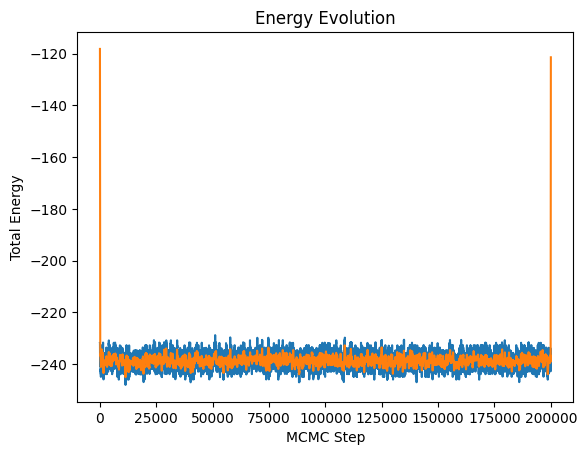

In [14]:
energy_average=[]
for i in range(len(energy_history)):
    energy_average.append(sum(energy_history[max(0,i-100):i+100])/200)
plt.plot(energy_history)
plt.plot(energy_average)
plt.xlabel("MCMC Step")
plt.ylabel("Total Energy")
plt.title("Energy Evolution")
plt.show()

In [10]:
print(particles)
print(sum(energy_history[-100:])/100)

['A' 'A' 'A' 'A' 'B' 'B' 'B' 'A' 'A' 'B' 'A' 'A' 'A' 'A' 'A' 'B' 'A' 'B'
 'B' 'A' 'B' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'A' 'A' 'A' 'A' 'A' 'A' 'B' 'B'
 'A' 'A' 'A' 'A' 'B' 'B' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'A' 'A' 'B' 'B' 'B'
 'A' 'B' 'B' 'B' 'A' 'A' 'A' 'A' 'B' 'B' 'A' 'B' 'A' 'A' 'A' 'B' 'A' 'B'
 'B' 'B' 'B' 'B' 'B' 'A' 'A' 'A' 'A' 'A']
-241.09650564332944
